In [1]:
import pandas as pd
import matplotlib
import numpy as np
from scipy import stats

Read GDP per capita figures from Wikipedia table

In [2]:
cities=pd.read_csv("List_of_U.S._metropolitan_areas_by_GDP_per_capita_1.csv", sep=",")

In [3]:
cities.head()


,Rank,Metropolitan area,2017 GDP per capita \r\n(chained 2009 US-Dollars)
0,1.0,"Midland, TX Metropolitan Statistical Area","174,749"
1,2.0,"San Jose-Sunnyvale-Santa Clara, CA Metropolita...","128,308"
2,3.0,"San Francisco–Oakland–Hayward, CA Metropolitan...","89,978"
3,4.0,"Bridgeport-Stamford-Norwalk, CT Metropolitan S...","87,082"
4,5.0,"Seattle-Tacoma-Bellevue, WA Metropolitan Stati...","80,833"


Read data from previous team's work, with some additional manual annotation of food stocks and annual program budget

In [4]:
foodbanks=pd.read_csv("foodbank_with_latlon.csv", sep="\t")

In [5]:
foodbanks.head()

,Food Bank,ID,Total Population,2021 Food Insecurity %,2021 Food Insecurity #,address,city,zip_code,state,statecode,latitude,longitude,lbs_distr,program_budget
0,Roadrunner Food Bank,1,2092454,0.155,323340,5840 Office Blvd NE,Albuquerque,87109,New Mexico,NM,35.1506,-106.5690,58958429.0,140942492.0
1,High Plains Food Bank,2,475188,0.161,76360,815 S. Ross|PO Box 31803,Amarillo,79120,Texas,TX,35.1964,-101.8034,NaN,NaN
2,"Food Bank of Alaska, Inc.",3,737068,0.129,95420,2192 Viking Drive,Anchorage,99501,Alaska,AK,61.2116,-149.8761,11073479.0,24880966.0
3,Atlanta Community Food Bank,4,6105046,0.117,715840,3400 N Desert Dr,Atlanta,30344,Georgia,GA,33.6919,-84.4480,NaN,213237927.0
4,Golden Harvest Food Bank,5,831422,0.139,115340,3310 Commerce Drive,Augusta,30909,Georgia,GA,33.4717,-82.0834,NaN,NaN


Annotate with GDP per capita of metro area

In [6]:
metros=list(cities["Metropolitan area"])

In [8]:
gdp=list(cities["2017 GDP per capita \r\n(chained 2009 US-Dollars)"])

In [9]:
city_match=list(foodbanks["city"])

Merge GDPs based on partial city match

In [10]:
gdps=[]
for c in city_match:
    out=np.nan
    for m in range(0, len(metros)):
        if c in metros[m]:
            out=int(gdp[m].replace(",", ""))
    gdps.append(out)

In [11]:
foodbanks["metro gdp per capita"]=gdps

In [12]:
foodbanks["metro gdp per capita"].isna().sum()

46

Fill missing GDP per capita with average value

In [13]:

foodbanks["metro gdp per capita"].fillna(int(foodbanks["metro gdp per capita"].mean()), inplace=True)


Linear regression to predict pounds of food per year from food insecure population

In [14]:
temp=foodbanks.dropna(subset=["lbs_distr"])

Linear correlation between pounds of food distributed and food insecure population

<AxesSubplot:xlabel='lbs_distr', ylabel='2021 Food Insecurity #'>

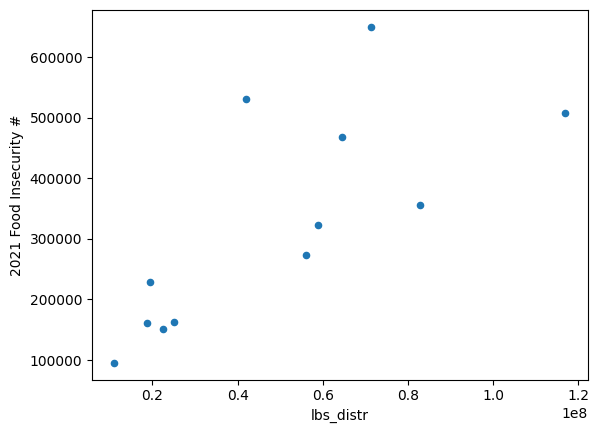

In [15]:
temp.plot.scatter(x="lbs_distr", y="2021 Food Insecurity #")

Less correlation between GDP per capita and pounds, so use insecurity pop to regress

<AxesSubplot:xlabel='lbs_distr', ylabel='metro gdp per capita'>

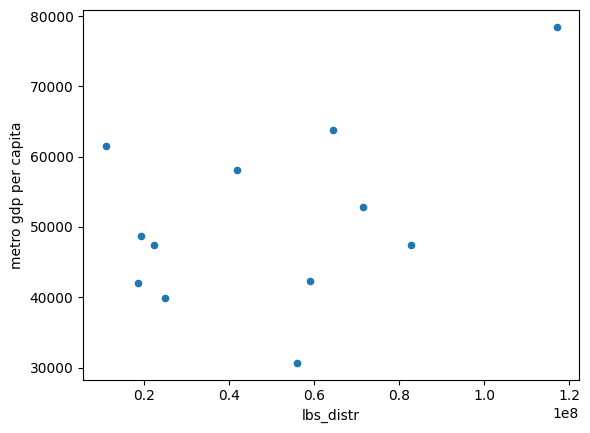

In [17]:
temp.plot.scatter(x="lbs_distr", y="metro gdp per capita")

In [18]:
x=temp["lbs_distr"]
y=temp["2021 Food Insecurity #"]

In [19]:
slope, intercept, r, p, std_err=stats.linregress(y, x)

In [20]:
def fill_pounds(row):
    if not pd.isna(row["lbs_distr"]):
        return row["lbs_distr"]
    else:
        return slope * row["2021 Food Insecurity #"] + intercept

In [21]:
foodbanks["estimated_pounds_per_year"]=foodbanks.apply(lambda row: fill_pounds(row), axis=1)

Linear regression to predict program budget from food insecure population

In [22]:
temp=foodbanks.dropna(subset=["program_budget"])

In [23]:
x=temp["program_budget"]
y=temp["2021 Food Insecurity #"]

Linear correlation between program budget and food insecure population

<AxesSubplot:xlabel='program_budget', ylabel='2021 Food Insecurity #'>

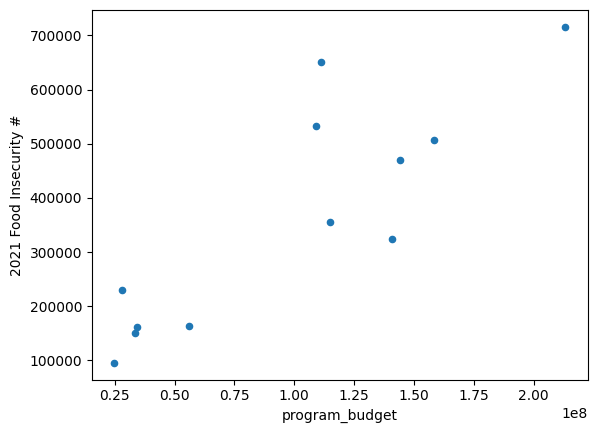

In [24]:
temp.plot.scatter(x="program_budget", y="2021 Food Insecurity #")

Less correlation between GDP per capita and pounds, so use insecurity pop to regress

<AxesSubplot:xlabel='program_budget', ylabel='metro gdp per capita'>

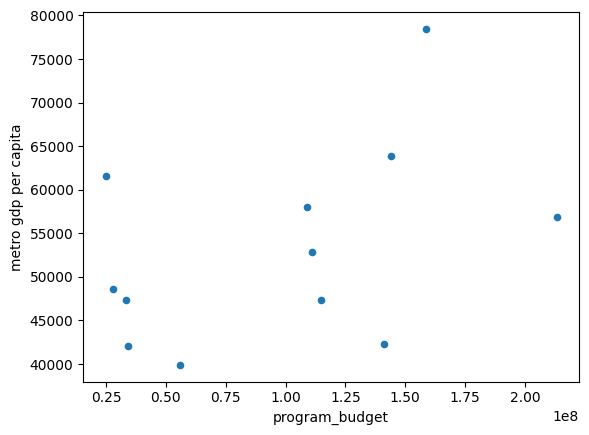

In [25]:
temp.plot.scatter(x="program_budget", y="metro gdp per capita")

In [26]:
slope, intercept, r, p, std_err=stats.linregress(y, x)

In [27]:
def fill_budget(row):
    if not pd.isna(row["program_budget"]):
        return row["program_budget"]
    else:
        return slope * row["2021 Food Insecurity #"] + intercept

In [28]:
foodbanks["estimated_budget"]=foodbanks.apply(lambda row: fill_budget(row), axis=1)

Save to CSV

In [30]:
foodbanks.to_csv("input.csv")